In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.special import inv_boxcox
from statsmodels.api import qqplot
import seaborn as sns
from statsmodels.api import OLS
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.stats import skewnorm, norm, gamma
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools

%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("datasets-14446-19502-country_profile_variables.csv")
df.head()

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),Economy: Industry (% of GVA),Economy: Services and other activity (% of GVA),Employment: Agriculture (% of employed),Employment: Industry (% of employed),Employment: Services (% of employed),Unemployment (% of labour force),Labour force participation (female/male pop. %),Agricultural production index (2004-2006=100),Food production index (2004-2006=100),International trade: Exports (million US$),International trade: Imports (million US$),International trade: Balance (million US$),"Balance of payments, current account (million US$)",Population growth rate (average annual %),Urban population (% of total population),Urban population growth rate (average annual %),"Fertility rate, total (live births per woman)","Life expectancy at birth (females/males, years)","Population age distribution (0-14 / 60+ years, %)",International migrant stock (000/% of total pop.),Refugees and others of concern to UNHCR (in thousands),Infant mortality rate (per 1000 live births,Health: Total expenditure (% of GDP),Health: Physicians (per 1000 pop.),Education: Government expenditure (% of GDP),Education: Primary gross enrol. ratio (f/m per 100 pop.),Education: Secondary gross enrol. ratio (f/m per 100 pop.),Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Seats held by women in national parliaments %,Mobile-cellular subscriptions (per 100 inhabitants),Mobile-cellular subscriptions (per 100 inhabitants).1,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)","Pop. using improved sanitation facilities (urban/rural, %)",Net Official Development Assist. received (% of GNI)
0,Afghanistan,SouthernAsia,652864,35530,54.40,106.30,20270,-2.4,623.20,23.3,23.30,53.30,61.6,10.0,28.5,8.6,19.3/83.6,125,125,1458,3568,-2110,-5121,3.2,26.70,4.0,5.3,63.5/61.0,43.2/4.1,382.4/1.2,1513.1,68.6,8.20,0.3,3.3,91.1/131.6,39.7/70.7,3.7/13.3,27.70,61.6,8.3,42,2.1,9.8/0.3,63,5,78.2/47.0,45.1/27.0,21.43,-99
1,Albania,SouthernEurope,28748,2930,106.90,101.90,11541,2.6,3984.20,22.4,26.00,51.70,41.4,18.3,40.3,15.8,40.2/61.0,134,134,1962,4669,-2707,-1222,-0.1,57.40,2.2,1.7,79.9/75.6,17.4/19.0,57.6/2.0,8.8,14.6,5.90,1.3,3.5,111.7/115.5,92.5/98.8,68.1/48.7,22.90,106.4,63.3,130,28.2,5.7/2.0,84,36,94.9/95.2,95.5/90.2,2.96,-99
2,Algeria,NorthernAfrica,2381741,41318,17.30,102.00,164779,3.8,4154.10,12.2,37.30,50.50,10.8,34.5,54.7,11.4,17.0/70.7,160,161,29992,47091,-17099,-27229,2.0,70.70,2.8,3.0,76.5/74.1,29.3/9.4,242.4/0.6,99.8,27.7,7.20,...,...,112.7/119.5,101.7/98.1,45.1/28.9,31.60,113.0,38.2,135,0.8,145.4/3.7,5900,55,84.3/81.8,89.8/82.2,0.05,-99
3,American Samoa,Polynesia,199,56,278.20,103.60,-99,-99,-99.00,-99,-99.00,-99.00,...,...,...,...,.../...,112,112,-99,-99,-99,-99,-~0.0,87.20,-0.1,2.6,77.8/71.1,33.3/9.0,23.2/41.8,-99,9.6,-99.00,-99,-99,-99,-99,-99,-99.00,...,-99,92,87.9,-99,-99,-99,100.0/100.0,62.5/62.5,-99,-99
4,Andorra,SouthernEurope,468,77,163.80,102.30,2812,0.8,39896.40,0.5,10.80,88.60,-99,-99,-99,-99,-99,-99,-99,100,1355,-1255,-99,-1.6,85.10,0.1,1.2,-99,14.4/19.0,42.1/59.7,-99,-99,8.10,3.7,3.3,-99,-99,-99,32.10,88.1,96.9,13,34.0,0.5/6.4,1,119,100.0/100.0,100.0/100.0,-99,-99


In [3]:
df.shape

(229, 50)

#Пункт 1

Хочу исследовать, как особенности населения влияют на безработицу в стране. Целевая непрерывная переменная - уровень безработицы в %

#Пункт 2

In [4]:
data = df[['Unemployment (% of labour force)', "Population growth rate (average annual %)",
           'Urban population (% of total population)', 'Seats held by women in national parliaments %']]
data["Men_domination"] = 1 * (df["Sex ratio (m per 100 f, 2017)"]>100)
data["Women_power_parabola"] = df['Seats held by women in national parliaments %'] ** 2

# Заполним вначале пропуски нормальными пропусками
for i in range(len(data)):
  for j in range(data.shape[1]):
    if data.iloc[i,j] == "...":
      data.iloc[i,j] = None
#
data["Unemployment (% of labour force)"] = data["Unemployment (% of labour force)"].astype("float32", errors='raise')
data["Population growth rate (average annual %)"] = data["Unemployment (% of labour force)"].astype("float32", errors='raise')

# заполним пропуски средним
from sklearn.impute import SimpleImputer

mis_replacer = SimpleImputer(strategy='mean')
data_no_mis = data.copy()
data_no_mis = pd.DataFrame(data=mis_replacer.fit_transform(data), columns=data.columns)

print(data_no_mis.isna().any().any())
data_no_mis.describe()

False


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,Unemployment (% of labour force),Population growth rate (average annual %),Urban population (% of total population),Seats held by women in national parliaments %,Men_domination,Women_power_parabola
count,229.00,229.00,229.00,229.00,229.00,229.00
mean,3.23,3.23,59.51,1.86,0.38,2080.53
std,23.84,23.84,25.21,45.67,0.49,3440.17
min,-99.00,-99.00,0.00,-99.00,0.00,0.00
25%,3.23,3.23,39.80,7.20,0.00,176.89
50%,6.20,6.20,59.90,17.10,0.00,524.41
75%,10.50,10.50,79.60,27.10,1.00,1444.00
max,31.40,31.40,100.00,61.30,1.00,9801.00


В качестве регрессоров буду использовать контрольные переменные состояния страны, то как растет население, какой процент из этого населения живет в городе, а также, представлена ли эта страна большинством мужчин или нет? В качестве непрерывных исследуемых регрессоров возьму долю женщин, сидящих в правлении, а также ее квадрат. Обосновано это гипотезой, что зависимость безработицы от женской представленности в правительстве имеет параболический вид, то есть, в стране, где правят одни мужчины, будет высокая безработица, по мере роста доли женщин, безработица будет падать, однако, после определенного момента все становится куда хуже, власть переходит к женщинам, и вот в стране уже опять огромная безработица. (Это лишь гипотеза, никакого дискриминационного посыла в ней нет)

#Пункт 3

Text(0.5, 0, 'Unemployement(% of labour force)')

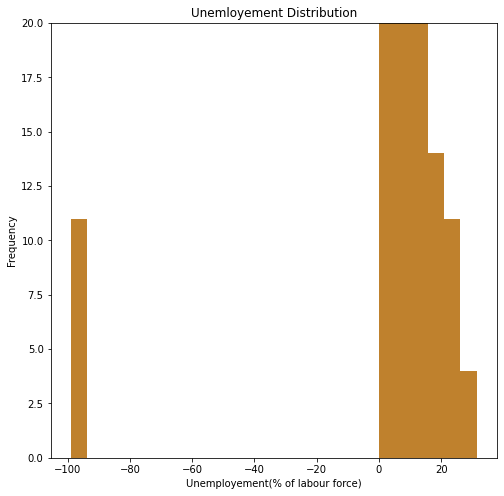

In [5]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot()

n, bins, patches = ax.hist(data_no_mis["Unemployment (% of labour force)"], bins = 25, stacked = True, density = False, color = "#bf812d")
ax.set_ylim(0, 20)
ax.set_title("Unemloyement Distribution")
ax.set_ylabel("Frequency")
ax.set_xlabel("Unemployement(% of labour force)")

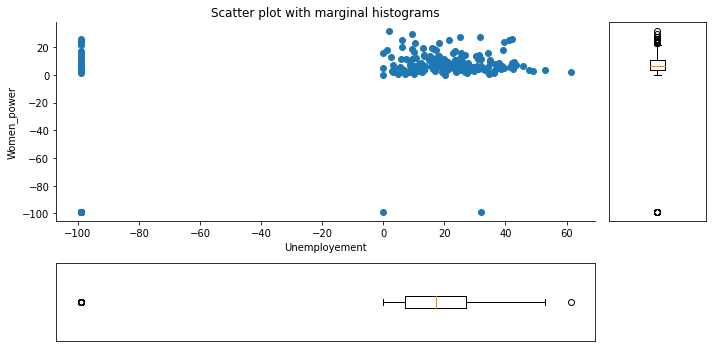

In [6]:
#Посмотрим детальнее на выбросы, возможно их удалим
a = data_no_mis['Seats held by women in national parliaments %']
b = data_no_mis["Unemployment (% of labour force)"]

fig = plt.figure(figsize = (10, 5))

gs = fig.add_gridspec(6, 6)
ax1 = fig.add_subplot(gs[:4, :-1])

ax1.scatter(a, b) 

ax1.set_xlabel("Unemployement")
ax1.set_ylabel("Women_power")

ax1.set_title("Scatter plot with marginal histograms")

ax1.spines["right"].set_color("None")
ax1.spines["top"].set_color("None")

ax2 = fig.add_subplot(gs[4:, :-1])
ax2.boxplot(a, vert = False)

ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(gs[:4, -1])
ax3.boxplot(b)

ax3.set_xticks([])
ax3.set_yticks([])

fig.tight_layout()

Наблюдаются выбросы по целевой переменной, удалю те, которые не входят в перцентиль (1,99)

In [7]:
data_no_mis = data_no_mis[data_no_mis["Unemployment (% of labour force)"] < np.percentile(data_no_mis["Unemployment (% of labour force)"],(1,99))[1]]
data_no_mis = data_no_mis[data_no_mis["Unemployment (% of labour force)"] > np.percentile(data_no_mis["Unemployment (% of labour force)"],(1,99))[0]]

data_no_mis.shape

(215, 6)

In [8]:
# Разделим выборку на Х и у

X = data_no_mis.drop(columns = "Unemployment (% of labour force)").copy()
X.rename(columns = {"Population growth rate (average annual %)":"Pop_growth",
                    "Urban population (% of total population)":"Urban_pop",
                    "Seats held by women in national parliaments %": "Women_power"},inplace=True)

y = data_no_mis["Unemployment (% of labour force)"].copy()
y.rename({"Unemployment (% of labour force)":"Unemployment"},inplace=True)
y.fillna(0)

0      8.60
1     15.80
2     11.40
3      3.23
5      6.60
       ... 
223    2.20
225    6.80
226   16.10
227    7.40
228    5.00
Name: Unemployment (% of labour force), Length: 215, dtype: float64

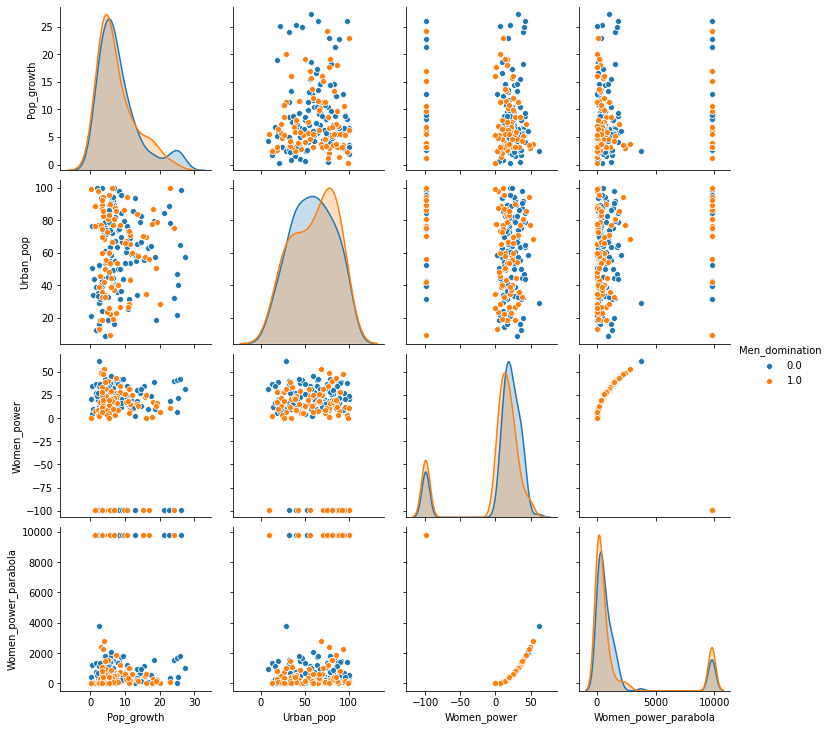

In [9]:
# взглянем на корреляцию признаков
sns.pairplot(X, hue = "Men_domination")

Классы сбалансированны, визуально мультиколлинеарности не наблюдается

Text(0.5, 0, 'Unemployement (% of labour force)')

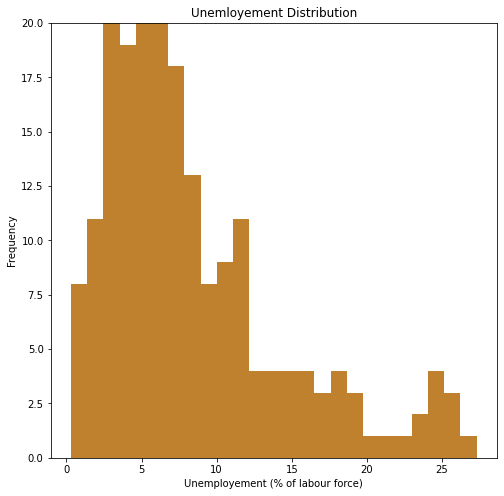

In [10]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot()

n, bins, patches = ax.hist(data_no_mis["Unemployment (% of labour force)"], bins = 25, stacked = True, density = False, color = "#bf812d")
ax.set_ylim(0, 20)
ax.set_title("Unemloyement Distribution")
ax.set_ylabel("Frequency")
ax.set_xlabel("Unemployement (% of labour force)")

#Пункт 4

#Пункт 5

In [11]:
# Для начала отнормируем данные

from sklearn.preprocessing import StandardScaler, MinMaxScaler
normalizer = StandardScaler()
X_real_norm_np = normalizer.fit_transform(X)
X_norm = pd.DataFrame(data=X_real_norm_np, columns=X.columns, index=X.index)
X_norm["Intercept"] = 1
X_norm.describe()

,Pop_growth,Urban_pop,Women_power,Men_domination,Women_power_parabola,Intercept
count,215.00,215.00,215.00,215.00,215.00,215.00
mean,0.00,0.00,0.00,-0.00,0.00,1.00
std,1.00,1.00,1.00,1.00,1.00,0.00
min,-1.33,-2.12,-2.50,-0.79,-0.57,1.00
25%,-0.74,-0.82,0.08,-0.79,-0.52,1.00
50%,-0.29,0.02,0.29,-0.79,-0.42,1.00
75%,0.43,0.81,0.52,1.26,-0.16,1.00
max,3.27,1.66,1.32,1.26,2.54,1.00


In [12]:
model_raw = OLS(y,X_norm).fit()
print(model_raw.summary())

                                   OLS Regression Results                                   
Dep. Variable:     Unemployment (% of labour force)   R-squared:                       1.000
Model:                                          OLS   Adj. R-squared:                  1.000
Method:                               Least Squares   F-statistic:                 1.016e+32
Date:                              Sat, 20 Jun 2020   Prob (F-statistic):               0.00
Time:                                      14:54:34   Log-Likelihood:                 6835.6
No. Observations:                               215   AIC:                        -1.366e+04
Df Residuals:                                   209   BIC:                        -1.364e+04
Df Model:                                         5                                         
Covariance Type:                          nonrobust                                         
                           coef    std err          t      P>|t|      

Ненулевыми коэффициентами модели получились только у роста населения и константы. Скорее всего, ковариационная матрица получилась вырожденной, и гардиентный спуск просто взорвался и обнулил некоторые оценки. Выводами модели может быть, что безработица в стране растен с таким же темпом прироста, что и насление (то есть при увеличнии населения на 1%, безработица увеличится на 5%). По сути, это логично, если учесть, что на рынке труда абсолютная занятость, и долгосрочный эффект роста населения не успевает сработать. То есть просто становится больше людей, а места уже заняты, им некуда идти работать, растет безработица.

In [13]:
# Построю Хубер-регресиию
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor(alpha=0.001)
Model_fit = huber.fit(X_norm, y)
Model_fit.coef_

array([5.87142616e+00, 1.44147766e-11, 4.55195047e-11, 3.62141257e-11,
       6.21748302e-11, 4.04777796e+00])

Коэффициента получились очень схожими

#Пункт 6

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2)

print("Размер обучения: ", X_train.shape[0])
print("Размер теста: ", X_test.shape[0])

Размер обучения:  172
Размер теста:  43


RMSE: 7.400109681909844e-15
MAE: 6.2585595620729755e-15
R-squared: 1.0


Text(0.5, 1.0, 'Predicted vs True values')

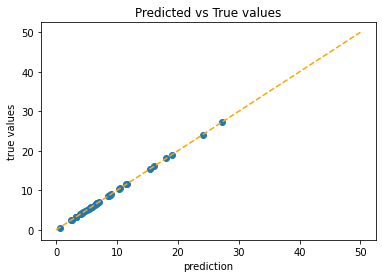

In [15]:
model2 = OLS(y_train,X_train).fit()

y_pred = model2.predict(X_test)

# print out the prediction scores
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(r2_score(y_test, y_pred)))
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(0,50,50), np.linspace(0,50,50), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.title('Predicted vs True values')

Кажется, любые преобразования уже бессмысленны, модель просто идеально предсказывает целевую переменную

RMSE: 1.9154948419142388e-16
MAE: 6.196593625814827e-17
R-squared: 1.0


Text(0.5, 1.0, 'Predicted vs True values')

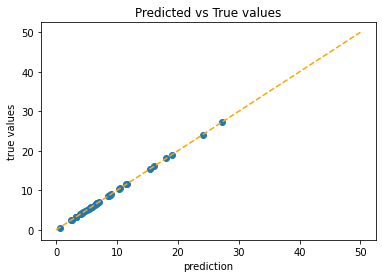

In [16]:
#Удалю некоторые регрессоры
model3 = OLS(y_train,X_train[["Pop_growth", "Intercept"]]).fit()

y_pred = model3.predict(X_test[["Pop_growth", "Intercept"]])

# print out the prediction scores
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('R-squared: {}'.format(r2_score(y_test, y_pred)))
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(0,50,50), np.linspace(0,50,50), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.title('Predicted vs True values')

Чисто технически, стало лучше, но по сути RMSE и так околонулевое

In [17]:
# Попробую преобразование Бокса-Кокса
y,l_lambda = st.boxcox(y+10**(-6))
y = y**l_lambda
train_data,fitted_lambda = st.boxcox(y_train)

test_data = st.boxcox(y_test, fitted_lambda)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE: 0.36848500284532637
MAE: 0.26366273152255665
R-squared: 0.884368017410814


Text(0.5, 1.0, 'Predicted vs True values')

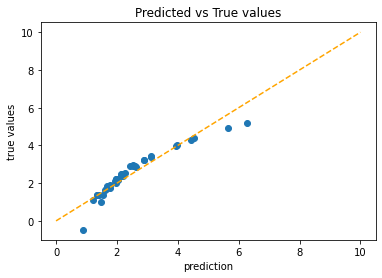

In [18]:
model4 = OLS(train_data,X_train).fit()

y_pred = model4.predict(X_test)

# print out the prediction scores
print('RMSE: {}'.format(np.sqrt(mean_squared_error(test_data, y_pred))))
print('MAE: {}'.format(mean_absolute_error(test_data, y_pred)))
print('R-squared: {}'.format(r2_score(test_data, y_pred)))
plt.scatter(y_pred, test_data)
plt.plot(np.linspace(0,10,10), np.linspace(0,10,10), c = 'orange', linestyle='--')
plt.xlabel('prediction')
plt.ylabel('true values')
plt.title('Predicted vs True values')

Вот так, по-идее, выглядит более-менее здоровая модель, но ошибка выросла, пробразование было ненужным

# Табалуга и река времени

#Пункт 1

In [19]:
T1 = [1]
T2 = [1, 1, 1]
T3 = [1, 1]
e3 = [np.random.normal(0, 1), np.random.normal(0, 1)]

for i in range(119):
  e = np.random.normal(0, 1)
  T1.append(0.8*T1[i] + e)

for i in range(117): 
  e = np.random.normal(0, 1)
  T2.append(0.1*T2[i+2]+0.2*T2[i+1]+0.3*T2[i] + e)

for i in range(118): 
  e3.append(np.random.normal(0, 1))
  T3.append(e3[i+2]+1.2*e3[i+1]+ 2*e3[i] + e)

df = pd.DataFrame(index = [i for i in range(120)], columns = ["TS1", "TS2", "TS3"])
df["TS1"] = T1
df["TS2"] = T2
df["TS3"] = T3
df.head(10)

,TS1,TS2,TS3
0,1.00,1.00,1.00
1,0.61,1.00,1.00
2,0.70,1.00,-2.36
3,2.09,-0.98,-0.75
4,1.98,-0.82,-2.34
5,1.59,-0.42,-3.15
6,2.10,-0.87,-4.19
7,2.78,2.09,-2.26
8,1.95,-1.17,1.35
9,0.41,0.47,0.94


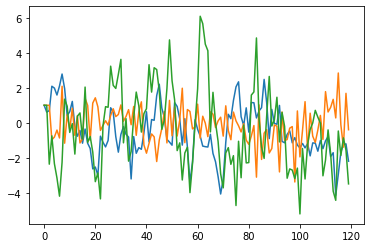

In [20]:
plt.plot(df)

Посмотрим подробнее на стационарность каждого ряда

Критерий Дики-Фуллера: p= 0.00037586020247259007


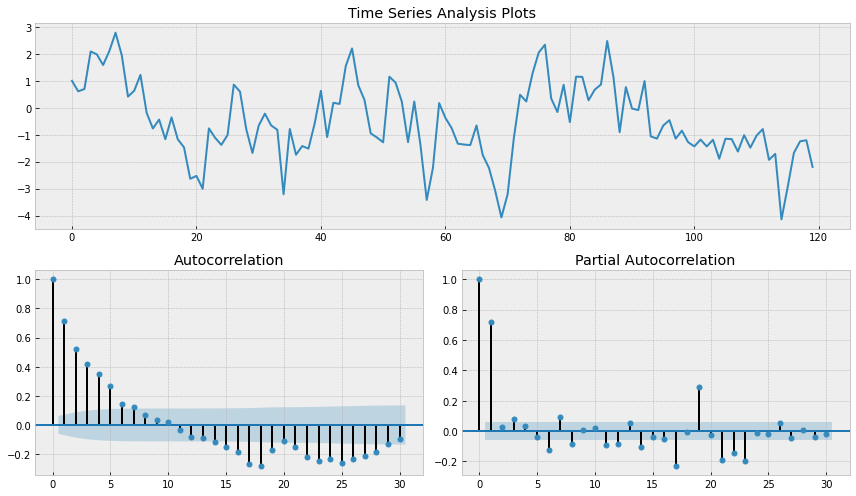

In [21]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=", sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 
#Первый ряд
tsplot(df.TS1, lags=30)

AR(1) модель, ряд стационарен, так как корни характеристического уравнения по модулю меньше 1

Критерий Дики-Фуллера: p= 0.0015887000091665982


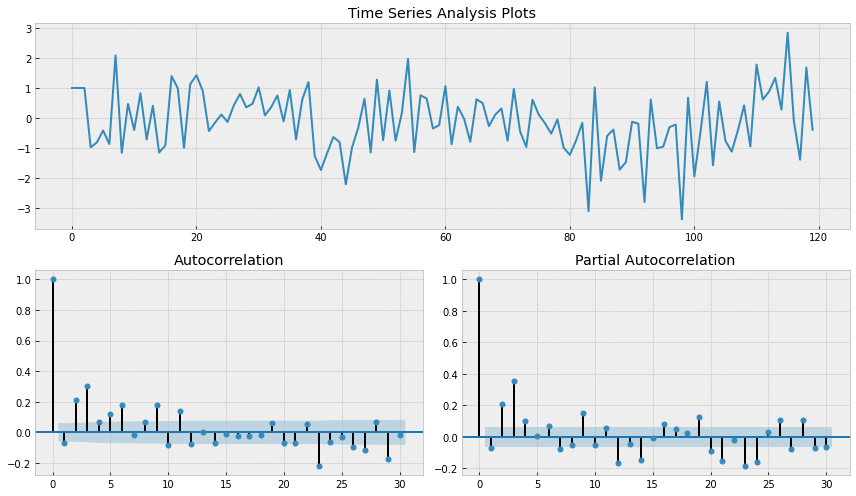

In [22]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=", sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 
#Второй ряд
tsplot(df.TS2, lags=30)

AR(3) модель, ряд стационарен, так как корни харк-ого ур-я по модулю меньше 1

Критерий Дики-Фуллера: p= 0.0005685593055227233


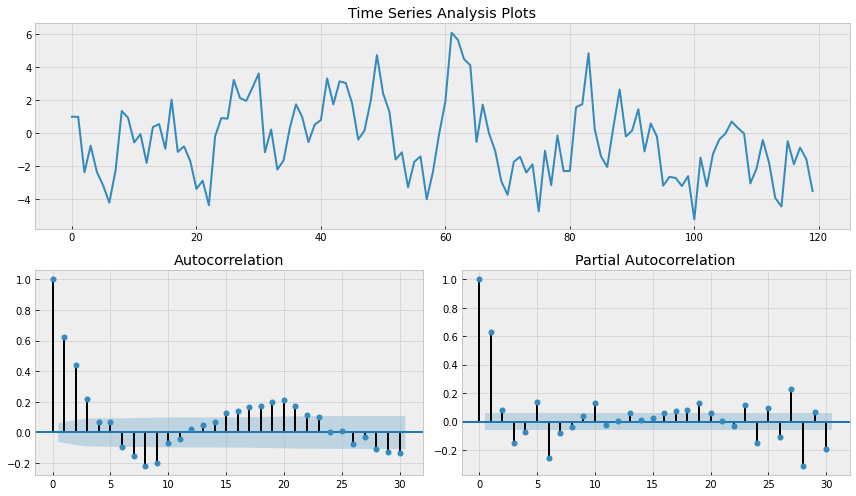

In [23]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=", sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 
#Третий ряд
tsplot(df.TS3, lags=30)

MA(2) модель, визуально видно, что ряд стационарен, у него нет тренда, и дисперсия примерно одинаковая